Convolutional Neural Networks

In [ ]:
import numpy as np
import os
import matplotlib.pylab as plt
from PIL import Image
from scipy import ndimage as ndi
from skimage.segmentation import mark_boundaries
from sklearn.model_selection import ShuffleSplit
import torch
from torchvision.transforms.functional import to_tensor, to_pil_image
from torch.utils.data import Dataset, Subset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import copy
import time
from albumentations import (HorizontalFlip, VerticalFlip, Compose, Resize)

In [ ]:
#Mount Google Drive to access files
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
training_set_path = "/content/drive/MyDrive/ID5030-Assignments/Week_6/training_set/"
testing_set_path = "/content/drive/MyDrive/ID5030-Assignments/Week_6/test_set/"

# **Create Custom Dataset**

In [ ]:
inputs = [(training_set_path + image) for image in os.listdir(training_set_path) if "Annotation" not in image]
inputs_annotations = [(training_set_path + image) for image in os.listdir(training_set_path) if "Annotation" in image]


print("Number of Input Images:", len(inputs))
print("Number of Annotations:", len(inputs_annotations))

Number of Input Images: 999
Number of Annotations: 999


In [ ]:
#Set a constant image height and width
image_height = 128
image_width = 192

---
\
**Combine the Input image and Input Annotation**

*Zip the input image and the corresponding annotation into a single list. So, whenever a image is indexed, the corresponding mask will be also indexed along with it*

---

In [ ]:
#Class to combine input image and the corresponding annotations 

class CombinedDataset(Dataset):
  def __init__(self, input_path, height = 224, width = 224):  
    self.input_path = input_path
    self.size = (height, width)
    print("Setting Image Size: (h,w) : ({}, {})".format(height, width))
    self.resize_image = Resize(height, width)
    
  def __len__(self):
    return len(self.input_path)
      
  def __getitem__(self, index):
    #Image
    picked_image_path = self.input_path[index]
    picked_image_file = Image.open(picked_image_path)
    picked_image = np.array(picked_image_file)

    #Annotation
    picked_annotation_path = picked_image_path.replace(".png", "_Annotation.png")
    picked_annotation_edges = Image.open(picked_annotation_path)
    picked_annotation = ndi.binary_fill_holes(picked_annotation_edges)
    picked_annotation = picked_annotation.astype("uint8")

    resized_image = self.resize_image(image=picked_image, mask=picked_annotation)
    picked_image = resized_image['image']
    picked_annotation = resized_image['mask']

    #Convert Image to Vector
    image = to_tensor(picked_image)            
    mask = 255*to_tensor(picked_annotation)    

    #Return corresponding Image and Mask        
    return image, mask

In [ ]:
#Class to combine input image and the corresponding annotations 

class CombinedAugmentedDataset(Dataset):
  def __init__(self, input_path, height = 224, width = 224):  
    self.input_path = input_path
    self.size = (height, width)
    print("Setting Image Size: (h,w) : ({}, {})".format(height, width))
    self.transformation = Compose([ Resize(height, width), HorizontalFlip(p=0.5), VerticalFlip(p=0.5)])
    
  def __len__(self):
    return len(self.input_path)
      
  def __getitem__(self, index):
    #Image
    picked_image_path = self.input_path[index]
    picked_image_file = Image.open(picked_image_path)
    picked_image = np.array(picked_image_file)

    #Annotation
    picked_annotation_path = picked_image_path.replace(".png", "_Annotation.png")
    picked_annotation_edges = Image.open(picked_annotation_path)
    picked_annotation = ndi.binary_fill_holes(picked_annotation_edges)
    picked_annotation = picked_annotation.astype("uint8")

    augmented_output = self.transformation(image=picked_image, mask=picked_annotation)
    picked_image = augmented_output['image']
    picked_annotation = augmented_output['mask']   
  
    #Convert Image to Vector
    image = to_tensor(picked_image)            
    mask = 255*to_tensor(picked_annotation)    

    #Return corresponding Image and Mask        
    return image, mask

In [ ]:
#Dataset Splitter - Train and Validation
#80% for Training and 20% for Validation
split_dataset = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

Without Image Augmentation

In [ ]:
#Combined Training Dataset
training_data = CombinedDataset(inputs, height = image_height, width = image_width)

Setting Image Size: (h,w) : (128, 192)


In [ ]:
indices=range(len(training_data))

for train_index, val_index in split_dataset.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))

input_train = Subset(training_data, train_index)
input_validation = Subset(training_data, val_index)

799
----------
200


In [ ]:
print("Training Set: ", len(input_train))
print("Validation Set: ", len(input_validation))

Training Set:  799
Validation Set:  200


In [ ]:
train_data = DataLoader(input_train, batch_size=4, shuffle=True, pin_memory=True)
val_data = DataLoader(input_validation, batch_size=8, shuffle=False, pin_memory=True) 

With Image Augmentation

In [ ]:
#Combined Training Dataset
training_data_augmented = CombinedAugmentedDataset(inputs, height = image_height, width = image_width)

Setting Image Size: (h,w) : (128, 192)


In [ ]:
input_train_augmented = Subset(training_data_augmented, train_index)
input_validation_augmented = Subset(training_data_augmented, val_index)

In [ ]:
print("Training Set: ", len(input_train_augmented))
print("Validation Set: ", len(input_validation_augmented))

Training Set:  799
Validation Set:  200


In [ ]:
train_data_augmented = DataLoader(input_train_augmented, batch_size=4, shuffle=True, pin_memory=True)
val_data_augmented = DataLoader(input_validation_augmented, batch_size=8, shuffle=False, pin_memory=True) 

# **Custom Encoder-Decoder CNN**

**Creating the CNN Model**

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, params):
      super(CustomCNN, self).__init__()
        
      C, H, W = params["input_shape"]
      initial_filters = params["initial_filters"] 
      num_outputs = params["num_outputs"] 

      #Encoder
      self.encoder_conv1 = nn.Conv2d(C, initial_filters, kernel_size=3, stride=1, padding=1)
      self.encoder_conv2 = nn.Conv2d(initial_filters, 2*initial_filters, kernel_size=3, stride=1, padding=1)
      self.encoder_conv3 = nn.Conv2d(2*initial_filters, 4*initial_filters, kernel_size=3, padding=1)
      self.encoder_conv4 = nn.Conv2d(4*initial_filters, 8*initial_filters, kernel_size=3, padding=1)
      self.encoder_conv5 = nn.Conv2d(8*initial_filters, 16*initial_filters, kernel_size=3, padding=1)

      #Upsample Layer
      self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

      #Decoder
      self.decoder_conv1 = nn.Conv2d(16*initial_filters, 8*initial_filters, kernel_size=3, padding=1)
      self.decoder_conv2 = nn.Conv2d(8*initial_filters, 4*initial_filters, kernel_size=3, padding=1)
      self.decoder_conv3 = nn.Conv2d(4*initial_filters, 2*initial_filters, kernel_size=3, padding=1)
      self.decoder_conv4 = nn.Conv2d(2*initial_filters, initial_filters, kernel_size=3, padding=1)

      #Output
      self.conv_out = nn.Conv2d(initial_filters, num_outputs , kernel_size=3, padding=1)   
    
    def forward(self, x):
      #Encoder
      #Convolutional Layer-1
      c1 = self.encoder_conv1(x)
      a1 = F.relu(c1)

      #Max Pooling
      a11 = F.max_pool2d(a1, 2, 2)
      #Convolutional Layer-2
      c2 = self.encoder_conv2(a11)
      a2 = F.relu(c2)

      #Max Pooling
      a22 = F.max_pool2d(a2, 2, 2)
      #Convolutional Layer-3
      c3 = self.encoder_conv3(a22)
      a3 = F.relu(c3)

      #Max Pooling
      a33 = F.max_pool2d(a3, 2, 2)
      #Convolutional Layer-4
      c4 = self.encoder_conv4(a33)
      a4 = F.relu(c4)

      #Max Pooling
      a44 = F.max_pool2d(a4, 2, 2)
      #Convolutional Layer-5
      c5 = self.encoder_conv5(a44)
      a5 = F.relu(c5)

      #Decoder
      #Unroll or Upsample
      a55 = self.upsample(a5)
      #Convolutional Layer-1
      c6 = self.decoder_conv1(a55)
      a6 = F.relu(c6)

      #Upsample
      a66 = self.upsample(a6)
      #Convolutional Layer-2
      c7 = self.decoder_conv2(a66)
      a7 = F.relu(c7)

      #Upsample
      a77 = self.upsample(a7)
      #Convolutional Layer-3
      c8 = self.decoder_conv3(a77)
      a8 = F.relu(c8)

      #Upsample
      a88 = self.upsample(a8)
      #Convolutional Layer-4
      c9 = self.decoder_conv4(a88)
      a9 = F.relu(c9)
      
      #Output Layer
      y_hat = self.conv_out(a9)
      
      return y_hat 

In [ ]:
def dice_loss(pred, target, smooth = 1e-5):
  intersection = (pred * target).sum(dim=(2,3))
  union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) 
  dice = 2.0 * (intersection + smooth) / (union+ smooth)    
  loss = 1.0 - dice
  return loss.sum(), dice.sum()

In [ ]:
def loss_function(pred, target):
  bce = F.binary_cross_entropy_with_logits(pred, target,  reduction='sum')
  pred = torch.sigmoid(pred)
  dlv, _ = dice_loss(pred, target)
  loss = bce  + dlv
  return loss

In [ ]:
def metrics_batch(pred, target):
  pred = torch.sigmoid(pred)
  _, metric = dice_loss(pred, target)
  return metric

In [ ]:
def loss_batch(loss_func, output, target, opt=None):   
  loss = loss_func(output, target)
  with torch.no_grad():
    pred = torch.sigmoid(output)
    _, metric_b = dice_loss(pred, target)
  if opt is not None:
    opt.zero_grad()
    loss.backward()
    opt.step()
  return loss.item(), metric_b

In [ ]:
def get_learning_rate(opt):
  for param_group in opt.param_groups:
      return param_group['lr'] 

In [ ]:
def loss_epoch(model, loss_fun, data, validation_sanity_check=False, opt=None):
  running_loss=0.0
  running_metric=0.0
  len_data = len(data.dataset)
  for xb, yb in data:
    xb = xb.to(device)
    yb = yb.to(device)
    output = model(xb)
    loss_b, metric_b = loss_batch(loss_fun, output, yb, opt)
    running_loss += loss_b    
    if metric_b is not None:
      running_metric+=metric_b
    if validation_sanity_check is True:
      break
  loss=running_loss/float(len_data)
  metric=running_metric/float(len_data)

  return loss, metric  

In [ ]:
def train_model(model, params):
  #Initial Arguments
  num_epochs = params["num_epochs"]
  optimizer = params["optimizer"]
  train_input = params["input_train"]
  validation_input = params["input_validation"]
  validation_sanity_check = params["validation_sanity_check"]
  lr_modifier = params["lr_scheduler"]
  weights_path = params["weights_path"]
  loss_fn = params["loss_function"]

  #Set Variables
  loss_history={
      "train": [],
      "validation": []}
  
  metric_history={
      "train": [],
      "validation": []}    

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss=float('inf')    
  
  #Run Epochs
  for epoch in range(num_epochs):
      start_time = time.time()
      current_lr = get_learning_rate(optimizer)
      print('Epoch {}/{} [{}]'.format(epoch+1, num_epochs, "="*20), end = "")   

      #Train Model
      model.train()
      train_loss, train_metric = loss_epoch(model, loss_fn, train_input, validation_sanity_check, opt = optimizer)
      loss_history["train"].append(train_loss)
      metric_history["train"].append(train_metric.to('cpu').numpy())
      
      #Validate Model
      model.eval()
      with torch.no_grad():
        val_loss, val_metric = loss_epoch(model, loss_fn, validation_input, validation_sanity_check)
      loss_history["validation"].append(val_loss)
      metric_history["validation"].append(val_metric.to('cpu').numpy()) 

      end_time = time.time()
      epoch_time = round(end_time-start_time,2)
      print(" - {}s - lr: {}".format(epoch_time, current_lr), end="")
      print(" - loss: %.6f - dice: %.2f" %(train_loss,100*train_metric), end = "")
      print(" - val_loss: %.6f - val_dice: %.2f" %(val_loss,100*val_metric), end="\n\n")   
      
      #Check change in loss, if loss gets decreased, save the weights
      if val_loss < best_loss:
          best_loss = val_loss
          best_model_wts = copy.deepcopy(model.state_dict())
          torch.save(model.state_dict(), weights_path)

      #Adjust learning rate based on loss
      lr_modifier.step(val_loss)
      if current_lr != get_learning_rate(optimizer):
          print("--"*30)
          print("Loading best model weights!")
          print("--"*30, end="\n\n")
          model.load_state_dict(best_model_wts) 

  model.load_state_dict(best_model_wts)
  return model, loss_history, metric_history  

In [ ]:
#Training Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#Save Model Weights
path2models= "/content/drive/MyDrive/ID5030-Assignments/Week_6/models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

In [ ]:
model_params ={
        "input_shape": (1,image_height,image_width), #Channel, Height, Width
        "initial_filters": 16, 
        "num_outputs": 1
        }

seg_model = CustomCNN(model_params)
seg_model = seg_model.to(device)

In [ ]:
print(seg_model)

CustomCNN(
  (encoder_conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  (decoder_conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [ ]:
summary(seg_model, (1, image_height, image_width))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 192]             160
            Conv2d-2           [-1, 32, 64, 96]           4,640
            Conv2d-3           [-1, 64, 32, 48]          18,496
            Conv2d-4          [-1, 128, 16, 24]          73,856
            Conv2d-5           [-1, 256, 8, 12]         295,168
          Upsample-6          [-1, 256, 16, 24]               0
            Conv2d-7          [-1, 128, 16, 24]         295,040
          Upsample-8          [-1, 128, 32, 48]               0
            Conv2d-9           [-1, 64, 32, 48]          73,792
         Upsample-10           [-1, 64, 64, 96]               0
           Conv2d-11           [-1, 32, 64, 96]          18,464
         Upsample-12         [-1, 32, 128, 192]               0
           Conv2d-13         [-1, 16, 128, 192]           4,624
           Conv2d-14          [-1, 1, 1

**Training the model**

In [ ]:
adam_optimizer = torch.optim.Adam(seg_model.parameters(), lr=4e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(adam_optimizer, mode='min', factor=0.65, patience=10, verbose=True)

In [ ]:
params_train={
    "num_epochs": 100,
    "optimizer": adam_optimizer,
    "input_train": train_data,
    "input_validation": val_data,
    "validation_sanity_check": False,
    "loss_function": loss_function,
    "lr_scheduler": lr_scheduler,
    "weights_path": path2models+"weights.pt",
}

In [ ]:
model, loss_hist, metric_hist = train_model(seg_model, params_train)

Epoch 1/100 [====================] - 26.12s - lr: 0.0004 - loss: 10909.463834 - dice: 48.46 - val_loss: 7409.276719 - val_dice: 64.74

Epoch 2/100 [====================] - 27.73s - lr: 0.0004 - loss: 7578.334825 - dice: 65.53 - val_loss: 7951.036543 - val_dice: 63.28

Epoch 3/100 [====================] - 26.79s - lr: 0.0004 - loss: 7385.411046 - dice: 66.09 - val_loss: 7045.681406 - val_dice: 70.22

Epoch 4/100 [====================] - 25.97s - lr: 0.0004 - loss: 7313.788412 - dice: 66.83 - val_loss: 7273.775156 - val_dice: 64.72

Epoch 5/100 [====================] - 26.02s - lr: 0.0004 - loss: 7235.701847 - dice: 67.01 - val_loss: 6954.463027 - val_dice: 68.55

Epoch 6/100 [====================] - 26.01s - lr: 0.0004 - loss: 7084.672965 - dice: 67.45 - val_loss: 7181.454355 - val_dice: 70.03

Epoch 7/100 [====================] - 26.27s - lr: 0.0004 - loss: 7032.719835 - dice: 67.88 - val_loss: 6905.385254 - val_dice: 66.91

Epoch 8/100 [====================] - 26.08s - lr: 0.0004 - lo

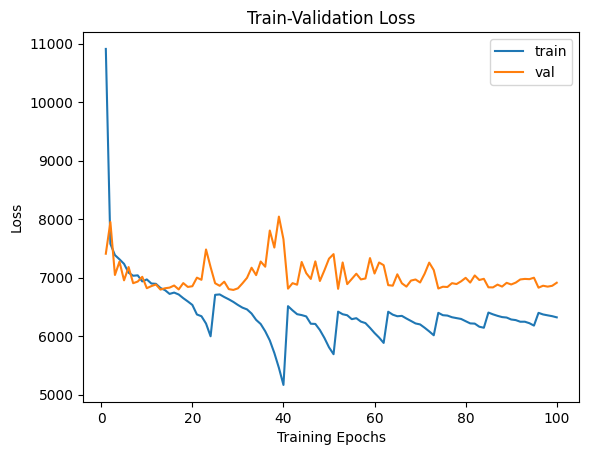

In [ ]:
num_epochs=params_train["num_epochs"]

#Plot Training and Validation Loss
plt.title("Train-Validation Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["validation"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

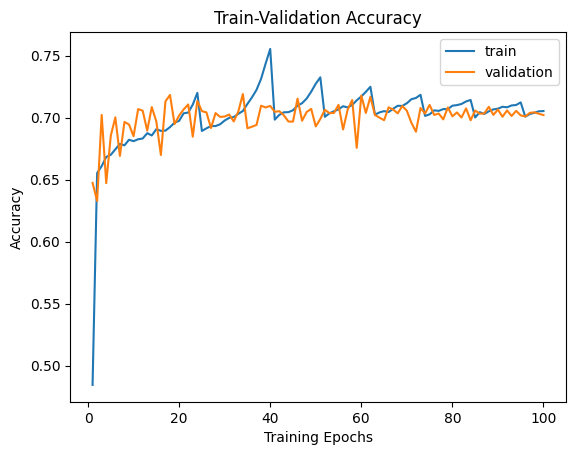

In [ ]:
#Plot Training and Validation Accuracy
plt.title("Train-Validation Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["validation"],label="validation")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

The above explains the classic case of over-fitting. To avoid over-fitting, the following measures are taken:

1. Image Augmentation
2. Increasing the batch size and learning rate (This reduces the validation loss)
3. Add dropout layers or weight decay(regularization)

---
**With Image Augmentation Input**

To improve the performance if the CNN, the following section implements Image Augmentation.

In [ ]:
model_params_augmented ={
        "input_shape": (1,image_height,image_width), #Channel, Height, Width
        "initial_filters": 16, 
        "num_outputs": 1
        }

seg_model_augmented = CustomCNN(model_params_augmented)
seg_model_augmented = seg_model_augmented.to(device)

In [ ]:
adam_optimizer_augmented = torch.optim.Adam(seg_model_augmented.parameters(), lr=3e-4)
lr_scheduler_augmented = torch.optim.lr_scheduler.ReduceLROnPlateau(adam_optimizer_augmented, mode='min', factor=0.5, patience=20, verbose=1)

In [ ]:
params_train_augmented={
    "num_epochs": 100,
    "optimizer": adam_optimizer_augmented,
    "input_train": train_data_augmented,
    "input_validation": val_data,
    "validation_sanity_check": False,
    "lr_scheduler": lr_scheduler_augmented,
    "loss_function": loss_function,
    "weights_path": path2models+"weights_augmented.pt"
}

In [ ]:
model_augmented, loss_hist_augmented, metric_hist_augmented = train_model(seg_model_augmented, params_train_augmented)

Epoch 1/100 [====================] - 58.36s - lr: 0.0003 - loss: 10897.428565 - dice: 47.70 - val_loss: 6607.555625 - val_dice: 67.70

Epoch 2/100 [====================] - 27.08s - lr: 0.0003 - loss: 6195.132031 - dice: 70.87 - val_loss: 4908.690117 - val_dice: 78.10

Epoch 3/100 [====================] - 25.57s - lr: 0.0003 - loss: 4493.750424 - dice: 77.80 - val_loss: 3689.499746 - val_dice: 81.78

Epoch 4/100 [====================] - 25.98s - lr: 0.0003 - loss: 3429.562416 - dice: 82.59 - val_loss: 2748.248325 - val_dice: 87.31

Epoch 5/100 [====================] - 25.83s - lr: 0.0003 - loss: 2787.515659 - dice: 85.92 - val_loss: 2701.402051 - val_dice: 86.43

Epoch 6/100 [====================] - 26.53s - lr: 0.0003 - loss: 2391.734802 - dice: 87.60 - val_loss: 1929.153672 - val_dice: 91.06

Epoch 7/100 [====================] - 25.9s - lr: 0.0003 - loss: 2016.050906 - dice: 89.84 - val_loss: 1939.108789 - val_dice: 89.70

Epoch 8/100 [====================] - 26.01s - lr: 0.0003 - los

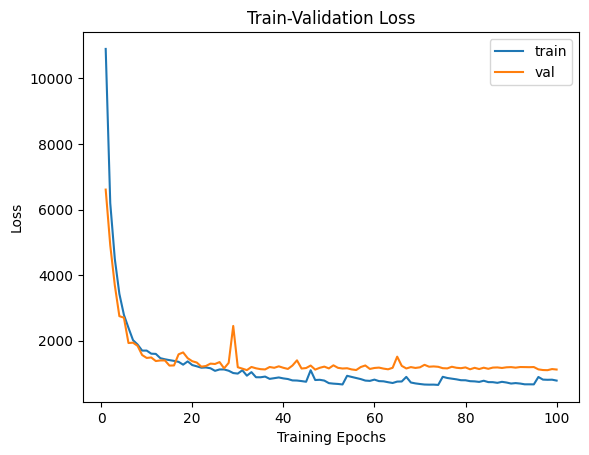

In [ ]:
num_epochs_augmented=params_train_augmented["num_epochs"]

#Plot Training and Validation Loss
plt.title("Train-Validation Loss")
plt.plot(range(1,num_epochs_augmented+1),loss_hist_augmented["train"],label="train")
plt.plot(range(1,num_epochs_augmented+1),loss_hist_augmented["validation"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

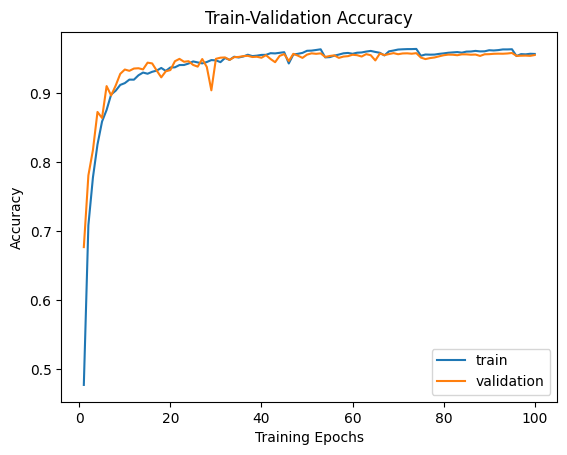

In [ ]:
#Plot Training and Validation Accuracy
plt.title("Train-Validation Accuracy")
plt.plot(range(1,num_epochs_augmented+1),metric_hist_augmented["train"],label="train")
plt.plot(range(1,num_epochs_augmented+1),metric_hist_augmented["validation"],label="validation")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

**Model Testing**

In [ ]:
test_inputs = [(testing_set_path + image) for image in os.listdir(testing_set_path) if "Annotation" not in image]
np.random.seed(20)
test_images = np.random.choice(test_inputs, 4)

In [ ]:
def test_model(model, test_images):
  for image_path in test_images:
      img = Image.open(image_path)
      img = img.resize((image_width,image_height))
      img_t = to_tensor(img).unsqueeze(0).to(device)
      pred = model(img_t.cuda()).cpu()
      pred = torch.sigmoid(pred)[0]
      mask_pred = (pred[0]>=0.5)

      plt.figure()
      plt.subplot(1, 3, 1) 
      plt.imshow(img, cmap="gray")
      
      plt.subplot(1, 3, 3) 
      img_mask=mark_boundaries(np.array(img), np.array(mask_pred), outline_color=(0,1,0), color=(0,1,0))
      plt.imshow(img_mask)

In [ ]:
model.eval()

CustomCNN(
  (encoder_conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  (decoder_conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

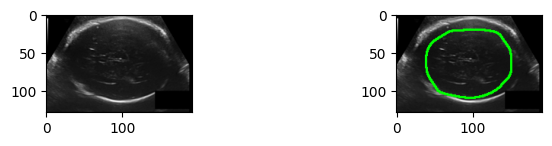

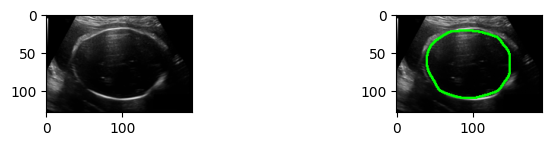

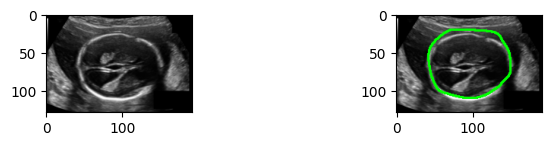

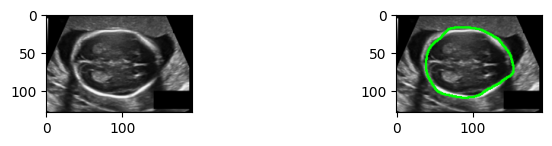

In [ ]:
test_model(model, test_images)

In [ ]:
model_augmented.eval()

CustomCNN(
  (encoder_conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  (decoder_conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decoder_conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

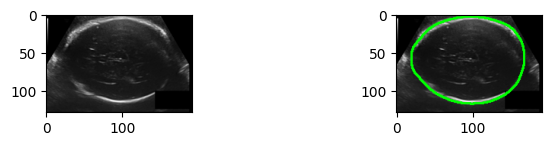

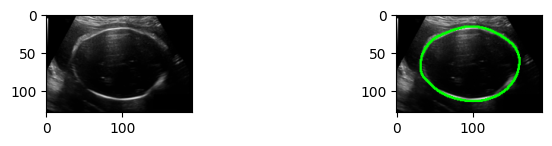

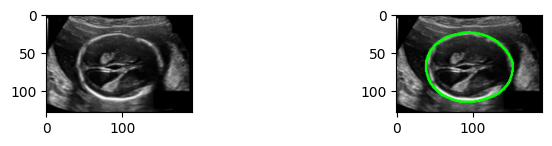

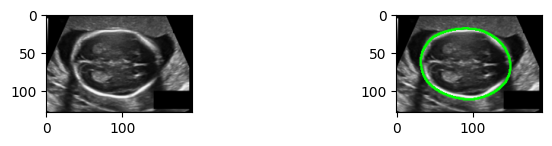

In [ ]:
test_model(model_augmented, test_images)

# **UNet Implementation**

In [ ]:
class UNET(nn.Module):
    def __init__(self, params):
        super(UNET, self).__init__()
        C, H, W = params["input_shape"]
        num_outputs = params["num_outputs"]
      
        self.conv1 = self.contract_block(C, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, num_outputs, 3, 1)

        #device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

    def forward(self, x):
        
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):
        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):
        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1))
        return expand

In [ ]:
unet_params ={
        "input_shape": (1,image_height,image_width), #Channel, Height, Width
        "num_outputs": 1
        }

unet = UNET(unet_params)
unet_model = unet.to(unet.device)

In [ ]:
print(unet_model)

UNET(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kerne

In [ ]:
summary(unet_model, (1, image_height, image_width))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 192]           1,600
       BatchNorm2d-2         [-1, 32, 128, 192]              64
              ReLU-3         [-1, 32, 128, 192]               0
            Conv2d-4         [-1, 32, 128, 192]          50,208
       BatchNorm2d-5         [-1, 32, 128, 192]              64
              ReLU-6         [-1, 32, 128, 192]               0
         MaxPool2d-7           [-1, 32, 64, 96]               0
            Conv2d-8           [-1, 64, 64, 96]          18,496
       BatchNorm2d-9           [-1, 64, 64, 96]             128
             ReLU-10           [-1, 64, 64, 96]               0
           Conv2d-11           [-1, 64, 64, 96]          36,928
      BatchNorm2d-12           [-1, 64, 64, 96]             128
             ReLU-13           [-1, 64, 64, 96]               0
        MaxPool2d-14           [-1, 64,

**Training the model**

In [ ]:
adam_optimizer_unet = torch.optim.Adam(unet_model.parameters(), lr=3e-4, weight_decay = 1e-15)
lr_scheduler_unet = torch.optim.lr_scheduler.ReduceLROnPlateau(adam_optimizer_unet, mode='min', factor=0.5, patience=10, verbose=True)

In [ ]:
params_train_unet={
    "num_epochs": 100,
    "optimizer": adam_optimizer_unet,
    "input_train": train_data_augmented,
    "input_validation": val_data,
    "validation_sanity_check": False,
    "lr_scheduler": lr_scheduler_unet,
    "loss_function": loss_function,
    "weights_path": path2models+"unet_weights.pt",
}

In [ ]:
model_unet, loss_hist_unet, metric_hist_unet = train_model(unet_model, params_train_unet)

Epoch 1/100 [====================] - 30.9s - lr: 0.0003 - loss: 1781.795178 - dice: 89.41 - val_loss: 1851.615181 - val_dice: 89.92

Epoch 2/100 [====================] - 31.22s - lr: 0.0003 - loss: 1683.504583 - dice: 90.01 - val_loss: 1828.970405 - val_dice: 90.27

Epoch 3/100 [====================] - 30.31s - lr: 0.0003 - loss: 1674.979734 - dice: 90.08 - val_loss: 1720.406338 - val_dice: 90.54

Epoch 4/100 [====================] - 30.45s - lr: 0.0003 - loss: 1622.270931 - dice: 90.50 - val_loss: 1789.328950 - val_dice: 90.64

Epoch 5/100 [====================] - 31.63s - lr: 0.0003 - loss: 1560.128580 - dice: 90.90 - val_loss: 1640.234653 - val_dice: 91.20

Epoch 6/100 [====================] - 30.74s - lr: 0.0003 - loss: 1520.248540 - dice: 91.15 - val_loss: 1610.094229 - val_dice: 91.41

Epoch 7/100 [====================] - 31.01s - lr: 0.0003 - loss: 1568.786043 - dice: 90.95 - val_loss: 1678.436128 - val_dice: 90.98

Epoch 8/100 [====================] - 31.96s - lr: 0.0003 - loss

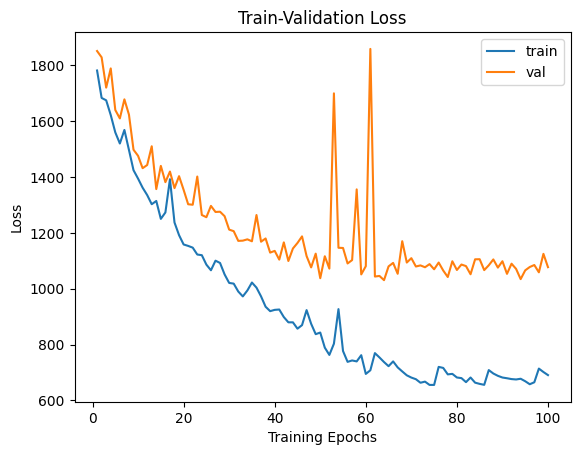

In [ ]:
num_epochs=params_train_unet["num_epochs"]

#Plot Training and Validation Loss
plt.title("Train-Validation Loss")
plt.plot(range(1,num_epochs+1),loss_hist_unet["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist_unet["validation"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()


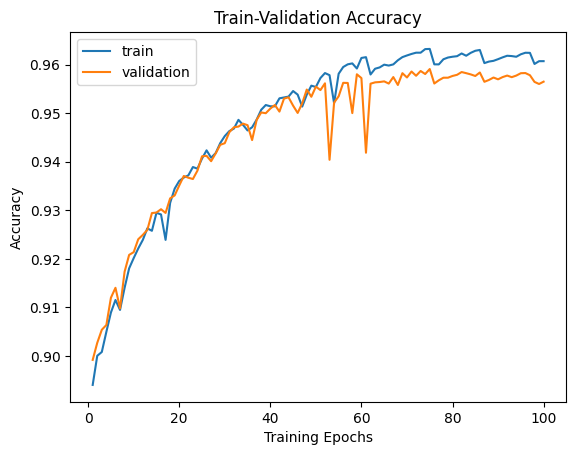

In [ ]:
#Plot Training and Validation Accuracy
plt.title("Train-Validation Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist_unet["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist_unet["validation"],label="validation")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [ ]:
model_unet.eval()

UNET(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kerne

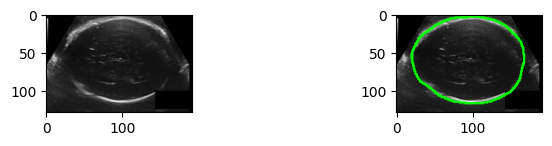

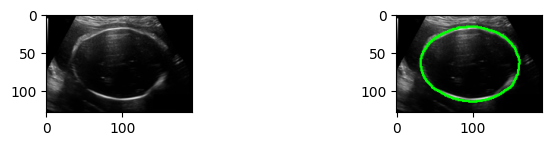

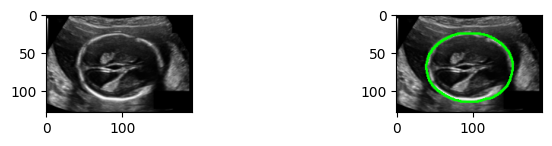

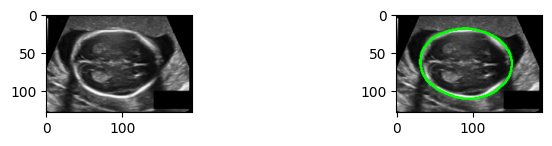

In [ ]:
test_model(model_unet, test_images)